# GPS Map matching with a Hidden Markov Model

In [1]:
from pprint import pprint

In [113]:
import gpxpy.gpx
import numpy as np
from gpxpy.gpx import GPXTrackPoint

def get_gps_points(file_path):
    with open(file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        
    gps_points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                gps_points.append(point)
    
    return np.array(gps_points, dtype=GPXTrackPoint)

In [114]:
gpx_path = 'Course_à_pied_dans_l_après_midi.gpx'
gps_points = get_gps_points(gpx_path)

In [115]:
pprint(gps_points)

array([GPXTrackPoint(35.235561, 129.089142, elevation=20.6, time=datetime.datetime(2024, 11, 13, 7, 37, 44, tzinfo=SimpleTZ('Z'))),
       GPXTrackPoint(35.235561, 129.089142, elevation=20.6, time=datetime.datetime(2024, 11, 13, 7, 37, 48, tzinfo=SimpleTZ('Z'))),
       GPXTrackPoint(35.235561, 129.089142, elevation=20.6, time=datetime.datetime(2024, 11, 13, 7, 37, 53, tzinfo=SimpleTZ('Z'))),
       ...,
       GPXTrackPoint(35.235141, 129.089131, elevation=20.3, time=datetime.datetime(2024, 11, 13, 9, 4, 35, tzinfo=SimpleTZ('Z'))),
       GPXTrackPoint(35.235146, 129.089124, elevation=20.3, time=datetime.datetime(2024, 11, 13, 9, 4, 36, tzinfo=SimpleTZ('Z'))),
       GPXTrackPoint(35.235152, 129.08912, elevation=20.3, time=datetime.datetime(2024, 11, 13, 9, 4, 37, tzinfo=SimpleTZ('Z')))],
      dtype=object)


In [116]:
print(len(gps_points))

4568


In [117]:
import matplotlib.pyplot as plt
from numpy.typing import NDArray

def plot_trajectory(gps_points : NDArray, title:str="GPS running Trajectory"):
    
    plt.figure(figsize=(8, 6))

    longitudes = [gps_point.longitude for gps_point in gps_points]
    latitudes = [gps_point.latitude for gps_point in gps_points]
    
    plt.plot(longitudes, latitudes, marker='o', linestyle='-')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='datalim')  # Equal scaling for axes
    plt.grid()
    plt.show()

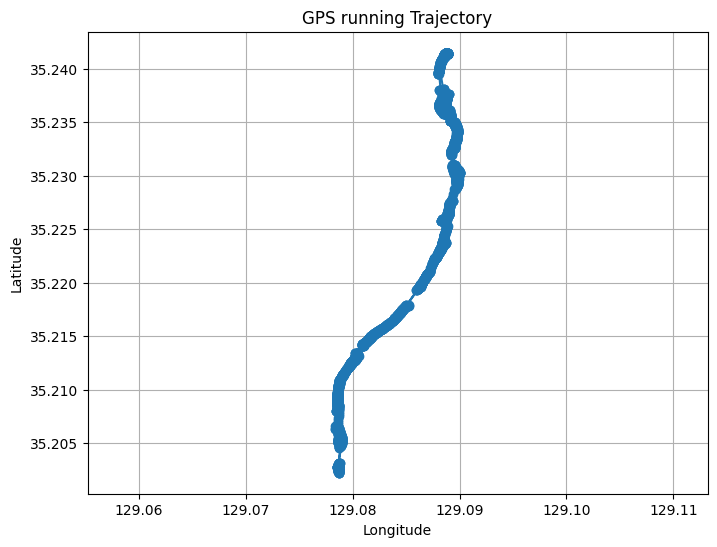

In [118]:
plot_trajectory(gps_points)

In [204]:
import osmnx as ox

def get_osm_data(bounding_box: tuple, network_type: str='drive'):
    
    osm_graph= ox.graph_from_bbox(bounding_box, network_type=network_type, simplify=True, truncate_by_edge=False)
    return osm_graph

In [205]:
longitudes = [gps_point.longitude for gps_point in gps_points]
latitudes = [gps_point.latitude for gps_point in gps_points]
bounding_box = (min(longitudes), min(latitudes), max(longitudes), max(latitudes))

osm_graph = get_osm_data(bounding_box)

In [206]:

for u, v, data in osm_graph.edges(data=True):
    # Add reverse edge if not already present
    if not osm_graph.has_edge(v, u):
        osm_graph.add_edge(v, u, **data)


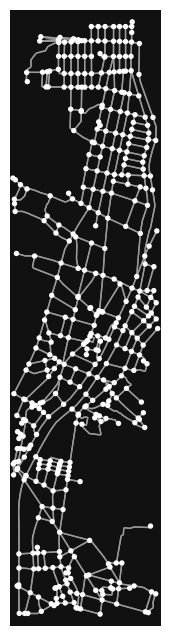

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [207]:
ox.plot_graph(osm_graph)


In [208]:
nodes, edges = ox.graph_to_gdfs(osm_graph, nodes=True, edges=True)
states = nodes

In [209]:
states

,y,x,street_count,junction,highway,geometry
osmid,,,,,,
414663685,35.224502,129.088318,3,NaN,NaN,POINT (129.08832 35.2245)
414664442,35.211795,129.078673,6,yes,NaN,POINT (129.07867 35.21179)
436724993,35.215279,129.081222,3,NaN,NaN,POINT (129.08122 35.21528)
436724994,35.216096,129.082436,3,NaN,NaN,POINT (129.08244 35.2161)
436724997,35.218720,129.084970,3,NaN,NaN,POINT (129.08497 35.21872)
...,...,...,...,...,...,...
9242168265,35.222775,129.089890,4,NaN,NaN,POINT (129.08989 35.22277)
9568166811,35.234670,129.085260,3,NaN,NaN,POINT (129.08526 35.23467)
9568166813,35.234438,129.085380,1,NaN,NaN,POINT (129.08538 35.23444)


In [210]:
import networkx as nx
from geopandas.geodataframe import GeoDataFrame
from networkx.classes.multidigraph import MultiDiGraph

def compute_transition_probabilities(states : GeoDataFrame, osm_graph : MultiDiGraph):
    """
    Compute the transition probability matrix for map matching.
    
    Parameters:
    - states (geopandas.GeoDataFrame): GeoDataFrame where each row represents an OSM edge with a geometry column.
    - osm_graph: The road network graph (osmnx format).
    
    Returns:
    - np.ndarray: Transition probability matrix.
    """
    n = len(states)
    stay_prob = 0.99
    
    transitions = np.zeros((n, n))
    for i, (node_from, _) in enumerate(states.iterrows()):
        for j, (node_to, _) in enumerate(states.iterrows()):
            
            if i < j:

                if (node_from not in osm_graph[node_to]) and (node_to not in osm_graph[node_from]):
                    transitions[i,j] = 0
                    transitions[j, i] = transitions[i, j]
        
                else:
                    try:
                        distance = nx.shortest_path_length(osm_graph, source=node_from, target=node_to, weight='length')

                    except nx.NetworkXNoPath:
                        distance = np.inf

                    transitions[i, j] = 1 / (1 + distance)
                    transitions[j, i] = transitions[i, j]


            elif i == j:
                transitions[i, j] = stay_prob
                

    # Normalize rows to sum to 1
    # transitions /= transitions.sum(axis=1, keepdims=True)
    
    for i in range(n):
        row_sum = np.sum(transitions[i])
        if row_sum > 0:
            # Scale the non-self transitions such that the total row sum is 1
            non_self_sum = 1 - stay_prob
            for j in range(n):
                if i != j:  # Non-self transitions
                    transitions[i, j] *= (non_self_sum / (row_sum - stay_prob))
            transitions[i] /= np.sum(transitions[i])  # Normalize the row to sum to 1
    return transitions

In [211]:
from scipy.spatial import distance_matrix
import numpy as np

# Extract GPS coordinates into a NumPy array
gps_coords = np.array([[point.longitude, point.latitude] for point in gps_points])

# Extract OSM node coordinates into a NumPy array
osm_coords = np.array([[geom.x, geom.y] for geom in states.geometry])

# Use scipy's distance_matrix to compute pairwise distances
observations = distance_matrix(gps_coords, osm_coords)
observations = observations.astype(np.float32)


In [212]:
from hmmlearn import hmm
from numpy.typing import NDArray

def setup_model(observations : NDArray, states : GeoDataFrame):
    # Number of states
    n_states = len(states)

    # Initialize Gaussian HMM
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", init_params="")

    # Set transition and initial probabilities
    model.startprob_ = np.full(n_states, 1 / n_states)  # Uniform start probabilities
    model.transmat_ = compute_transition_probabilities(states, osm_graph)

    # Set emission probabilities as Gaussian means and variances
    model.means_ = observations.mean(axis=0).reshape(-1, 1)
    model.covars_ = np.var(observations, axis=0).reshape(-1, 1)

    return model


In [213]:
print(observations.shape)

(4568, 438)


In [214]:
model = setup_model(observations, states) 
state_sequence = model.predict(observations)

In [215]:
def remove_redundancy(state_sequence):
    """
    Remove consecutive redundant states in the state sequence.
    
    Parameters:
    - state_sequence: A 1D array of state indices (OSM node indices).
    
    Returns:
    - cleaned_state_sequence: A 1D array where consecutive duplicate states are removed.
    """

    cleaned_state_sequence = []
    
    # Iterate over the state sequence and keep only the first state in each consecutive block
    for i, state in enumerate(state_sequence):
        if i == 0 or state != state_sequence[i - 1]:
            cleaned_state_sequence.append(state)
    
    return np.array(cleaned_state_sequence)



In [216]:
cleaned_state_sequence = remove_redundancy(state_sequence)
print(len(cleaned_state_sequence))


58


In [217]:
decoded_states = [states.iloc[label] for label in cleaned_state_sequence]

In [218]:
import plotly.graph_objects as go
import plotly.io as pio

# Set default Plotly renderer
pio.renderers.default = "browser"

def get_figure_map_result(gps_points, decoded_states, edges=None):



    latitudes = [gps_point.latitude for gps_point in gps_points]
    longitudes = [gps_point.longitude for gps_point in gps_points]

    # Create Plotly figure
    fig = go.Figure()

    # Add GPS run to the map
    fig.add_trace(go.Scattermapbox(
        lat=latitudes, 
        lon=longitudes,
        mode='markers+lines',  # Show both markers and lines
        marker=dict(size=5, color='red'),
        line=dict(width=2, color='blue'),
        name="GPS Run"
    ))

    
    latitude_decoded_states = [decoded_state.geometry.coords[0][1] for decoded_state in decoded_states]
    longitude_decoded_states = [decoded_state.geometry.coords[0][0] for decoded_state in decoded_states]


    fig.add_trace(go.Scattermapbox(
        lat= latitude_decoded_states,
        lon=longitude_decoded_states,
        mode='markers+lines',
        marker=dict(size=5, color='green'),
        line=dict(width=2, color='green'),
        name="OSM Road (decoded)",
    ))

    if edges is not None:
        edge_lines = []
        for _, row in edges.iterrows():
            # Create a line for each road segment
            edge_lines.append({
                'lat': [row['geometry'].coords[0][1], row['geometry'].coords[-1][1]], 
                'lon': [row['geometry'].coords[0][0], row['geometry'].coords[-1][0]]
            })

        # Add OSM roads to the map
        for i, edge in enumerate(edge_lines):
            if i == 0:
                showlegend = True
            else:
                showlegend = False

            fig.add_trace(go.Scattermapbox(
                lat=edge['lat'],
                lon=edge['lon'],
                mode='markers+lines',
                marker=dict(size=5, color='purple'),
                line=dict(width=2, color='purple'),
                name="OSM Road",
                showlegend=showlegend,
                opacity=0.2
                
            ))

    # Calculate the center and bounds of the GPS data
    min_lat, max_lat = min(latitudes), max(latitudes)
    min_lon, max_lon = min(longitudes), max(longitudes)

    # Calculate the center of the bounding box
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2

    # Calculate zoom level based on the bounding box size
    lat_range = max_lat - min_lat
    lon_range = max_lon - min_lon
    max_range = max(lat_range, lon_range)

    # Set a zoom level based on the bounding box size
    zoom = 15 - (max_range * 100)  # A simple way to adjust zoom level based on distance

    fig.update_layout(
        mapbox=dict(
            style="open-street-map",  # OpenStreetMap style
            center=dict(lat=center_lat, lon=center_lon),
            zoom=zoom
        ),
        title="Your GPS Run with OSM Roads",
        margin=dict(t=30, b=30, l=30, r=30),
        showlegend=True
    )

    return fig

In [219]:
fig = get_figure_map_result(gps_points, decoded_states)
fig.show()

In [220]:
import gpxpy.geo

def compute_distance_hmm(points):
    """
    Compute distances between successive OPSM points using gpx gpxpy's distance method.
    """
    distances = []
    for i in range(len(points) - 1):
        dist = gpxpy.geo.distance(
            latitude_1=points[i].geometry.coords[0][1], 
            longitude_1=points[i].geometry.coords[0][0],
            latitude_2=points[i + 1].geometry.coords[0][1],
            longitude_2=points[i + 1].geometry.coords[0][0],
            elevation_1=None,
            elevation_2=None,
            haversine=True
            )

        distances.append(dist)
    return (np.array(distances).sum())


In [221]:
import gpxpy.geo

def compute_distance_gps(points):
    """
    Compute distances between successive GPS points using gpxpy's distance method.
    
    Parameters:
    - points: List of GPXTrackPoint objects.
    
    Returns:
    - List of distances in meters between consecutive points.
    """
    distances = []
    for i in range(len(points) - 1):
        dist = gpxpy.geo.distance(
            latitude_1=points[i].latitude, 
            longitude_1=points[i].longitude,
            latitude_2=points[i + 1].latitude,
            longitude_2=points[i + 1].longitude,
            elevation_1=None,
            elevation_2=None,
            haversine=True
            )

        distances.append(dist)
    return (np.array(distances).sum())


In [222]:
distance_hmm = compute_distance_hmm(decoded_states)
print(distance_hmm)

8705.721397089947


In [ ]:
distance_gps = compute_distance_gps(gps_points)
print(distance_gps)

11617.909540463963


distance réelle:
8,42km